In [3]:
import random
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
from torch_geometric.data import Data
import json
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

Get speakers

In [4]:
speakers = np.array(['PM','ME','UI','ID'])
speaker_IDs = np.array([1, 2, 3, 4])
speaker = []

# Opening JSON file
f = open('training/IS1003d.json')

# returns JSON object as a dictionary
data = json.load(f)
for i in range(len(data)):
    name = data[i]['speaker']
    speaker.append([speaker_IDs[speakers==name][0]])

print(len(speaker))

1095


Get edges in graph

In [77]:
edge_from = []
edge_to = []

filename = "training/IS1003d.txt"
with open(filename) as f:
    for line in f:
        row = line.split()
        n1, n2 = int(row[0]), int(row[2])
        edge_from.append(n1)
        edge_to.append(n2)


Get labels

In [78]:
# Opening JSON file
f = open('training_labels.json')

# returns JSON object as a dictionary
data = json.load(f)

label = data['IS1003d']
label = [ys for ys in label]

In [99]:
edge_index = torch.tensor([edge_from,
                           edge_to], dtype=torch.long)
x = torch.tensor(speaker, dtype=torch.float)

y = torch.tensor(label, dtype=torch.long)

train_mask = torch.tensor([True for _ in range(len(y))])

graph = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=train_mask)

In [100]:
print(graph)

Data(x=[1095, 1], edge_index=[2, 1094], y=[1095], train_mask=[1095], val_mask=[1095])


Illustrate

/var/folders/0m/66g0_plj0kx3gn328ysf7pb80000gn/T/ipykernel_45105/3899443263.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


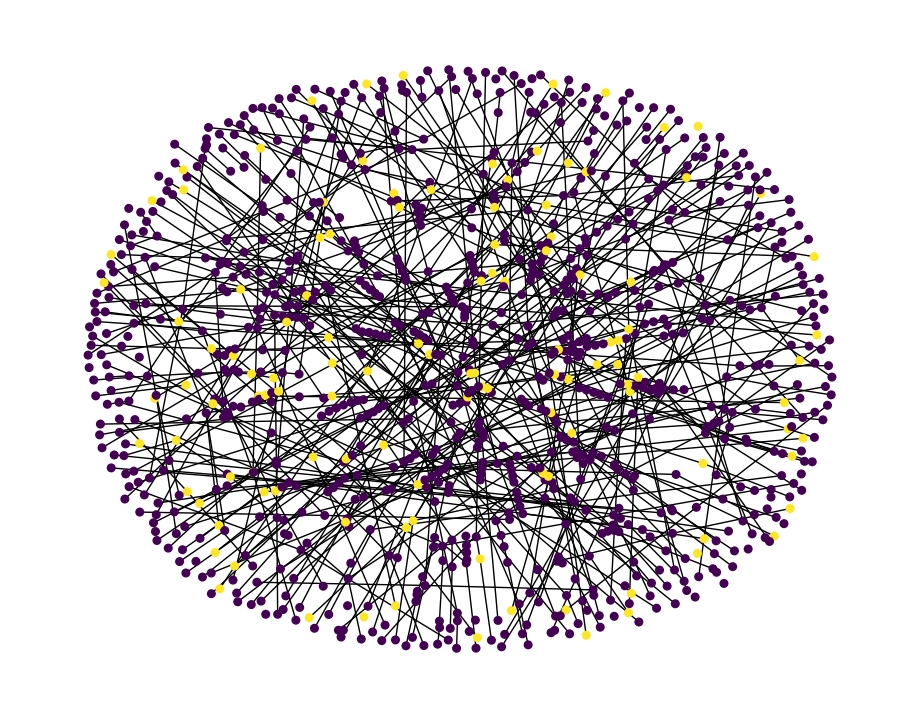

In [101]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [102]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(1, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 2)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

In [103]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc
  
  
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.386, Val Acc: 0.879
Epoch: 020, Train Loss: 0.369, Val Acc: 0.879
Epoch: 030, Train Loss: 0.369, Val Acc: 0.879
Epoch: 040, Train Loss: 0.367, Val Acc: 0.879
Epoch: 050, Train Loss: 0.367, Val Acc: 0.879
Epoch: 060, Train Loss: 0.367, Val Acc: 0.879
Epoch: 070, Train Loss: 0.367, Val Acc: 0.879
Epoch: 080, Train Loss: 0.367, Val Acc: 0.879
Epoch: 090, Train Loss: 0.367, Val Acc: 0.879
Epoch: 100, Train Loss: 0.367, Val Acc: 0.879
Epoch: 110, Train Loss: 0.367, Val Acc: 0.879
Epoch: 120, Train Loss: 0.367, Val Acc: 0.879
Epoch: 130, Train Loss: 0.367, Val Acc: 0.879
Epoch: 140, Train Loss: 0.367, Val Acc: 0.879
Epoch: 150, Train Loss: 0.367, Val Acc: 0.879


AttributeError: 'GlobalStorage' object has no attribute 'test_mask'

In [105]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 0.395, Val Acc: 0.879
Epoch: 020, Train Loss: 0.385, Val Acc: 0.879
Epoch: 030, Train Loss: 0.382, Val Acc: 0.879
Epoch: 040, Train Loss: 0.378, Val Acc: 0.879
Epoch: 050, Train Loss: 0.375, Val Acc: 0.879
Epoch: 060, Train Loss: 0.371, Val Acc: 0.879
Epoch: 070, Train Loss: 0.368, Val Acc: 0.879
Epoch: 080, Train Loss: 0.368, Val Acc: 0.879
Epoch: 090, Train Loss: 0.368, Val Acc: 0.879
Epoch: 100, Train Loss: 0.368, Val Acc: 0.879
Epoch: 110, Train Loss: 0.368, Val Acc: 0.879
Epoch: 120, Train Loss: 0.368, Val Acc: 0.879
Epoch: 130, Train Loss: 0.368, Val Acc: 0.879
Epoch: 140, Train Loss: 0.368, Val Acc: 0.879
Epoch: 150, Train Loss: 0.368, Val Acc: 0.879
Epoch: 160, Train Loss: 0.368, Val Acc: 0.879
Epoch: 170, Train Loss: 0.368, Val Acc: 0.879
Epoch: 180, Train Loss: 0.368, Val Acc: 0.879
Epoch: 190, Train Loss: 0.368, Val Acc: 0.879
Epoch: 200, Train Loss: 0.368, Val Acc: 0.879


AttributeError: 'GlobalStorage' object has no attribute 'test_mask'